## Lab3: Segmentation

### Segmentation: given an image *x*, classify each pixel of *x* into one possible class.

In general, image anlysis is done with CNN, that acts as an image-to-image transform, mapping each pixel of *x* to the corresponding class.
An image map (which is a function $f: \mathbb{R}^{m \times n \times c} \to \mathbb{R}^{m' \times n' \times c'}$) is required to do **segmentation** and some image processing tasks, but not for classification or image detection.


### Dataset

Carvana Image Masking Challenge

In [1]:
# Install kaggle library
!pip install kaggle

# Create a new folder .kaggle and move kaggle.json into that
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Allocate permissions for this file
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!kaggle competitions download -c carvana-image-masking-challenge

carvana-image-masking-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# The dataset is huge. For our experiments today, we just need a subset of it.
# Unzip train.zip and the corresponding masks. Not the HQ version.
!unzip -p carvana-image-masking-challenge.zip train.zip >train.zip
!unzip -p carvana-image-masking-challenge.zip train_masks.zip >train_masks.zip

# Unzip the zipped train files.
!unzip train.zip
!unzip train_masks.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: train_masks/0789bed99cb8_09_mask.gif  
 extracting: train_masks/0789bed99cb8_10_mask.gif  
 extracting: train_masks/0789bed99cb8_11_mask.gif  
 extracting: train_masks/0789bed99cb8_12_mask.gif  
  inflating: train_masks/0789bed99cb8_13_mask.gif  
  inflating: train_masks/0789bed99cb8_14_mask.gif  
  inflating: train_masks/0789bed99cb8_15_mask.gif  
  inflating: train_masks/0789bed99cb8_16_mask.gif  
 extracting: train_masks/0795e132d090_01_mask.gif  
 extracting: train_masks/0795e132d090_02_mask.gif  
 extracting: train_masks/0795e132d090_03_mask.gif  
 extracting: train_masks/0795e132d090_04_mask.gif  
 extracting: train_masks/0795e132d090_05_mask.gif  
 extracting: train_masks/0795e132d090_06_mask.gif  
 extracting: train_masks/0795e132d090_07_mask.gif  
 extracting: train_masks/0795e132d090_08_mask.gif  
 extracting: train_masks/0795e132d090_09_mask.gif  
 extracting: train_masks/0795e132d090_10_mask.gif  
 extracting: t

### Setup

Import libraries and prepare the code.

In [4]:
# Import libraries

import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import cv2

import tensorflow as tf
from tensorflow import keras as ks

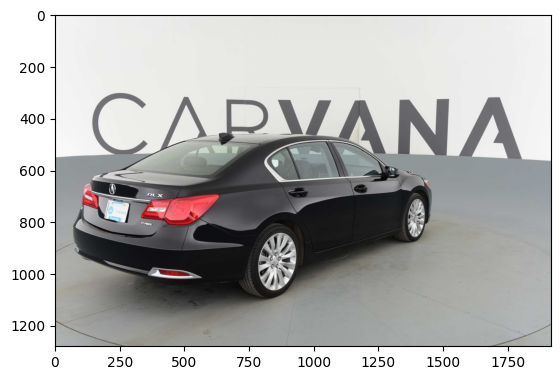

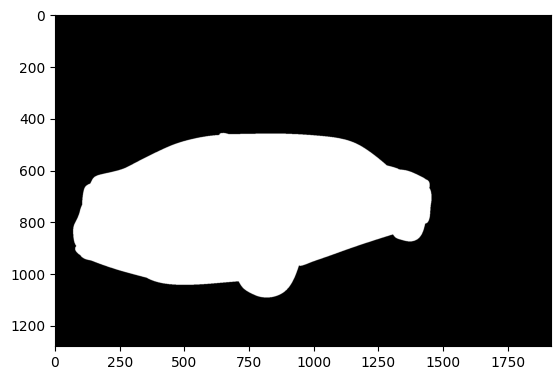

In [5]:
# Show the image and its mask

train_list = sorted(os.listdir('./train'))
mask_list = sorted(os.listdir('./train_masks'))

img = plt.imread(f'./train/{train_list[10]}')
mask = plt.imread(f'./train_masks/{mask_list[10]}')

plt.imshow(img)
plt.show()

plt.imshow(mask)
plt.show()

When dataset is too big, a generator needs to be used -> a numpy array is created and used as  dataset.

In [6]:
# Given the root path and a list of file names as input, 
# this function returns the dataset array:

def load_data_from_names(root_dir: str, fnames:list, shape=(256,256)) -> np.array:
  images = []

  for idx, img_name in enumerate(fnames):
    x = Image.open(os.path.join(root_dir,img_name))
    x = x.resize(shape)
    x = np.array(x)
    images.append(x)

    if idx%100 == 99:
      print(f'Processed {idx+1} images')
  return np.array(images)

# Load the names and create lists 
# containing the names of the files 
# in the folder and sort them
image_names = os.listdir('./train')
mask_names = os.listdir('./train_masks')
image_names.sort()
mask_names.sort()

# Since the first dataset is oo big, a smaller subset
# needs to be considered, in order to reduce the computational time
N = 2000
image_names = image_names[:N]
mask_names = mask_names[:N]

# Create data: consider 'x' as the input, 'y' as the output
x = load_data_from_names('./train', image_names)
y = load_data_from_names('./train_masks', mask_names)

# Print the dimensions
print(f'The dimension of the dataset is: {x.shape}')

Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
Processed 100 images
Processed 200 images
Processed 300 images
Processed 400 images
Processed 500 images
Processed 600 images
Processed 700 images
Processed 800 images
Processed 900 images
Processed 1000 images
Processed 1100 images
Processed 1200 images
Processed 1300 images
Processed 1400 images
Processed 1500 images
Processed 1600 images
Processed 1700 images
Processed 1800 images
Processed 1900 images
Processed 2000 images
The dimension of the dataset is: (2000, 256, 256, 3)


In [7]:
# At this point the dataset needs to be split into training set and test set

TRAIN_SIZE = 1800
x_train = x[:TRAIN_SIZE]
y_train = y[:TRAIN_SIZE]

x_test = x[TRAIN_SIZE:]
y_test = y[TRAIN_SIZE:]

print(f'Train size: {x_train.shape}, test size:{x_test.shape}')

Train size: (1800, 256, 256, 3), test size:(200, 256, 256, 3)


## Visualization

Visualize some image and the corresponding mask.

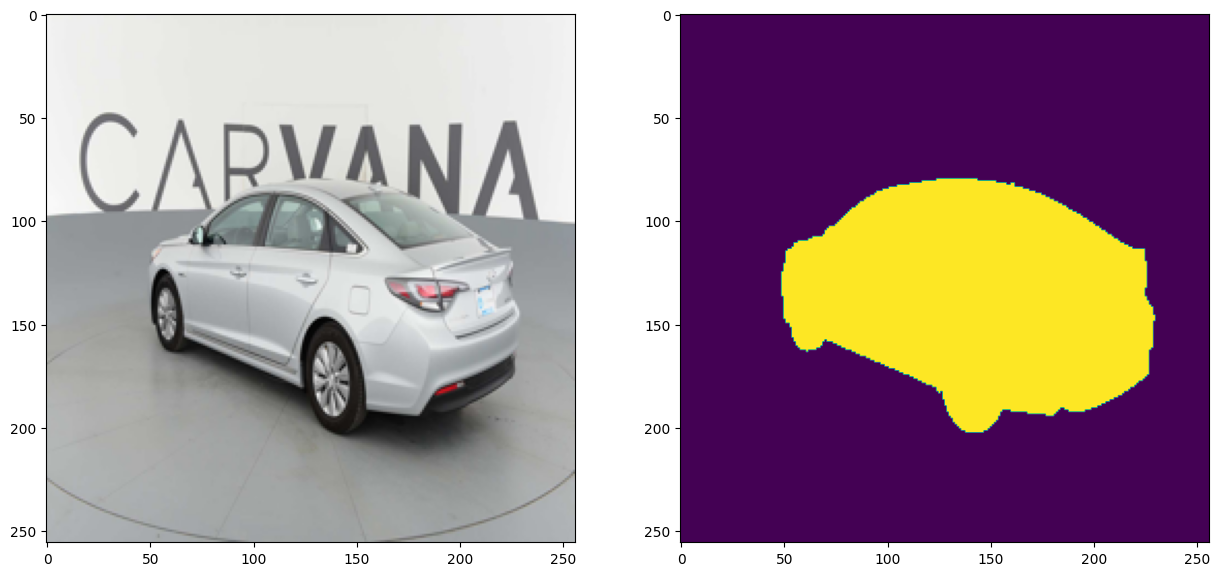

In [8]:
def show(x, y, title=None):
  plt.figure(figsize=(15,8))
  plt.subplot(1, 2, 1)
  plt.imshow(x)
  if title:
    plt.title(title[0])

  plt.subplot(1, 2, 2)
  plt.imshow(y)
  if title:
    plt.title(title[1])

  plt.show()

show(x_train[150], y_train[150])

## Model

In [9]:
def build_cnn(input_shape, n_ch, L = 3):
   x = ks.layers.Input(shape = input_shape)
   h = x

   for l in range(L):
     h = ks.layers.Conv2D(n_ch, kernel_size = 3, padding = 'same')(h)
     h = ks.layers.ReLU()(h)

     n_ch = 2*n_ch

   y = ks.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(h)
   return ks.models.Model(x, y)

CNN_model = build_cnn((256, 256, 3), 64, L = 3)
CNN_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

print(CNN_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 128)     73856     
                                                                 
 re_lu_1 (ReLU)              (None, 256, 256, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 256)     295168    
                                                                 
 re_lu_2 (ReLU)              (None, 256, 256, 256)     0     

A Convolutional layer has been used as the output layer, instead of a Dense layer, because we want to learn a mask, i.e. an image, not a number. So, in order to keep the image factor, the best way to do that is to use a Convolutional layer. (Convolutional layers are to be used when mapping from image to image, while Dense layers are *terrible* when working with image-to-image).

Set the hyperparameters: **batch size** and **number of epochs**. Then, visualize the behavior of training loss and validation loss, and of training accuracy and validation accuracy.

Epoch 1/20
102/102 [==============================] - 52s 373ms/step - loss: 0.7600 - accuracy: 0.8436 - val_loss: 0.3510 - val_accuracy: 0.8725
Epoch 2/20
102/102 [==============================] - 36s 354ms/step - loss: 0.3198 - accuracy: 0.8856 - val_loss: 0.2812 - val_accuracy: 0.8991
Epoch 3/20
102/102 [==============================] - 37s 364ms/step - loss: 0.2968 - accuracy: 0.8968 - val_loss: 0.2605 - val_accuracy: 0.9089
Epoch 4/20
102/102 [==============================] - 37s 365ms/step - loss: 0.2597 - accuracy: 0.9086 - val_loss: 0.2511 - val_accuracy: 0.9169
Epoch 5/20
102/102 [==============================] - 37s 363ms/step - loss: 0.2577 - accuracy: 0.9112 - val_loss: 0.2516 - val_accuracy: 0.9183
Epoch 6/20
102/102 [==============================] - 37s 364ms/step - loss: 0.2693 - accuracy: 0.9091 - val_loss: 0.2397 - val_accuracy: 0.9195
Epoch 7/20
102/102 [==============================] - 37s 365ms/step - loss: 0.2423 - accuracy: 0.9175 - val_loss: 0.2335 - val_ac

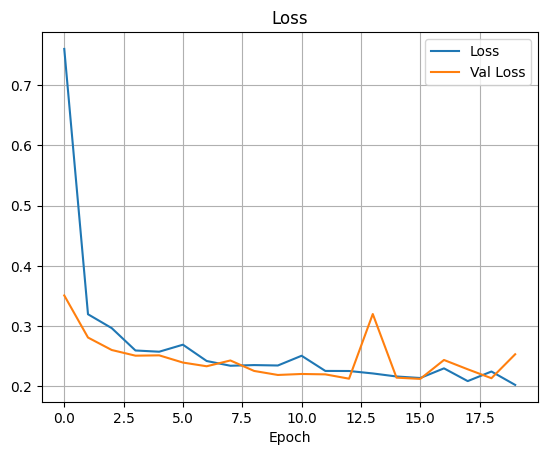

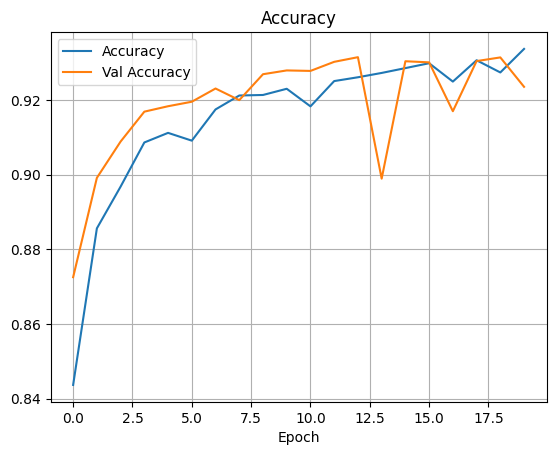

In [10]:
BATCH_SIZE = 16
N_EPOCHS = 20

history = CNN_model.fit(x_train, y_train,
                     batch_size = BATCH_SIZE,
                     epochs = N_EPOCHS,
                     validation_split=0.1)

# Check overfit
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

acc_history = history.history['accuracy']
val_acc_history = history.history['val_accuracy']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

CNN_model.save_weights('segmentation_train.h5')

In [27]:
CNN_model.load_weights('segmentation_train.h5')

## Evaluation

It is possible to evaluate the quality of segmantation in different ways. The following are the most improtant:
 - Accuracy
 - Intersection over Union (IoU)
 - Dice Coefficient

### Accuracy
Simply defined by considering the segmentation as a pixel-by-pixel classification.

### Intersection over Union
It is actually pretty intuitive. It is defined as the ratio between the intersection area between the predicted mask and the ground truth mask over the union between the two mask.

![](https://miro.medium.com/max/300/0*kraYHnYpoJOhaMzq.png)

Considering that the mask is a binary image, it is trivial to compute both the intersection and the union:
$$
\mu (A \cup B) + \mu (A \cap B) = \mu (A) + \mu (B)
$$

where $\mu(A)$ is defined to be the Area of A. 
Clearly, $IoU(y, y') \in [0, 1]$, and $IoU(y, y') = 1$ in the best case, where $y$ and $y'$ overlap perfectly, and $IoU(y, y') = 0$ when they don't overlap (worst case).



### Dice Coefficient

Defined by twice the overlapping area of the two masks, over the sum of the area of the two masks.

![](https://miro.medium.com/max/429/1*yUd5ckecHjWZf6hGrdlwzA.png)

The implementations of the IoU is similar to that of the Dice coefficient, since both of them use a binary mask (between 0 and 1).


In [14]:
from keras import backend as K
from keras.losses import binary_crossentropy

def iou_coeff(y_true, y_pred):
  smooth = 1

  # Basically you use the smooth to avoid division by 0.
  # If for some reason both the gt and the pred are 0's 
  # you will have an Inf and the weight propagation will ruin
  # the training procedure.
  # Note that you add it to both the numerator and denominator 
  # to prevent it from affecting the coefficient in any other case.

  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])  # axis=[1,2,3] mean the sum is being made on the three dims of the tensor
  union = K.sum(y_true, [1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection

  iou = K.mean((intersection + smooth) / (union + smooth), axis = 0)
  return iou

def dice_coeff(y_true, y_pred):
  smooth = 1

  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)

  intersection = K.sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f))
  return score

# Evaluation function
def evaluate_model(model, x, y, fun):
  y_pred = model.predict(x) # Use the model to predict the output
  y = np.expand_dims(y, -1) # We need to add the channel dimension on y

  y_pred = y_pred.astype('float32')
  y = y.astype('float32')

  return fun(y, y_pred)

iou = evaluate_model(CNN_model, x_test, y_test, iou_coeff)
dice = evaluate_model(CNN_model, x_test, y_test, dice_coeff)

print(f'The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.')


7/7 [==============================] - 1s 227ms/step
The IoU of the trained model is 0.5055217742919922, while its Dice coefficient is 0.6753161549568176.


1/1 [==============================] - 1s 510ms/step


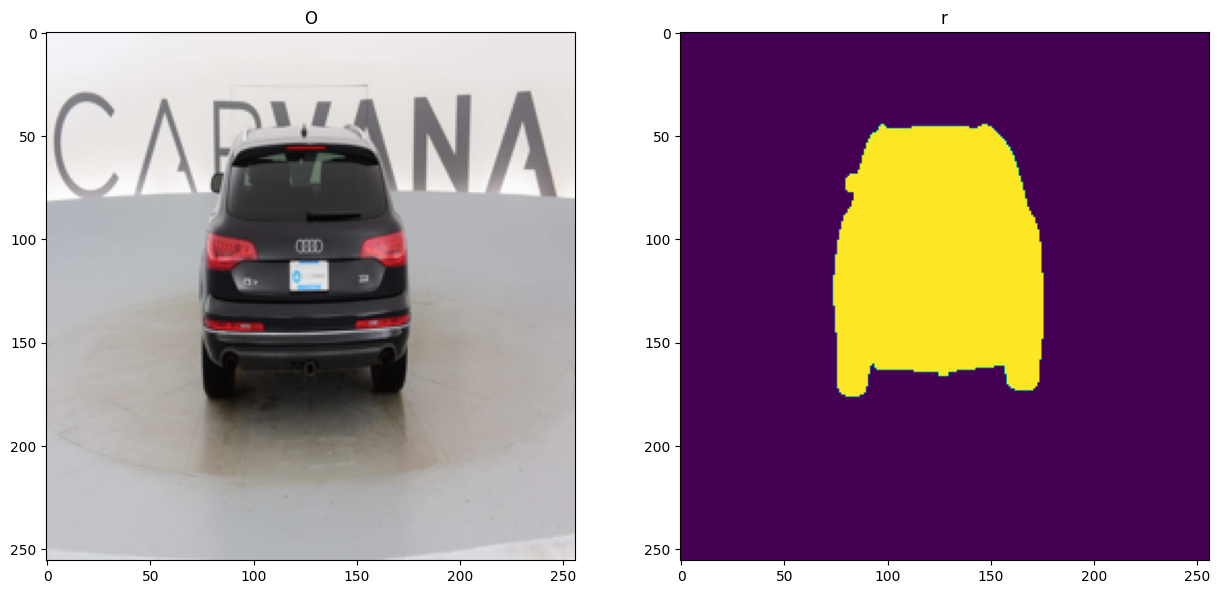

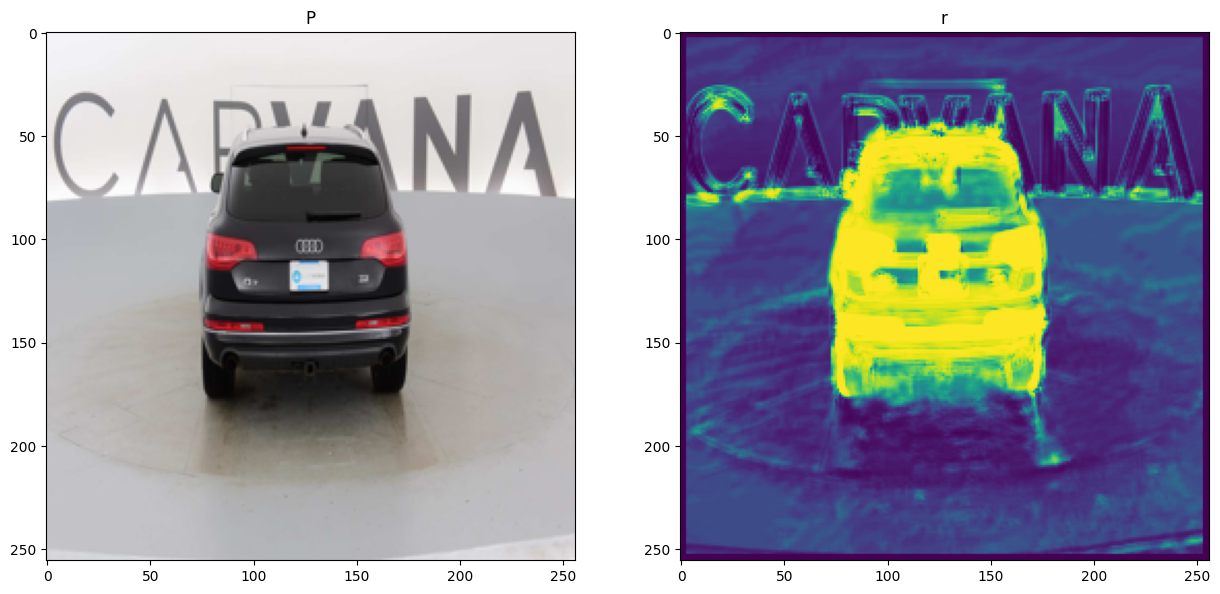

In [15]:
# Qualitative results

y_pred = CNN_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

## UNet

CNN, multi-level architecture.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

- Red arrow -> downsampling
- Green arrow -> upsampling
- Gray arrow -> keep the information, skip connection

Scale the model as large as possible.

The architecture of a UNet if based on the formula studied to compute the *receptive field* of a CNN:

$$
D' = S(D-1) + K
$$

where *D'* is the receptive field of the previous layer, *D* is the receptive field on the following layer, *S* is the stride and *K* is the kernel size.

A consequence of this fomrula is that the receptive field increases exponentially while moving down, linearly while moving right.

The drawback of downsampling, which is the information loss, is solved by UNet, by adding skip connections, that also act as training stabilizer. At every downsampling (implemented in this case as a MaxPooling 2D layer), the number of filters doubles, in order to reduce the impact of the dimensionality loss (the total number of pixels after downsampling is divided by 4).

In [19]:
# Build the UNet

def build_unet(input_shape, n_ch = 32, L=4, conv_per_L = 2):
  # L = number of floors
  # conv_per_L = number of convolutions every level

  input = ks.layers.Input(shape=input_shape)


    # DOWN

  backup_layers = [] 
  h = input
  for l in range(L):
    # Each floor in the descent phase
    for c in range(conv_per_L):
      h = ks.layers.Conv2D(n_ch, kernel_size = 3, strides  = 1, padding = 'same', activation = 'relu')(h)


    if l < L-1: # L-1 bc we don't want to downsample at the last level
        # Downsampling
      backup_layers.append(h)  # Keep the last layer 
      h = ks.layers.MaxPool2D(padding = 'same')(h)

      # Update the channels, double them (not mandatory)
      n_ch = 2*n_ch


    #UP

  for l in range(L-1):
      # Reduce the channels
    n_ch = n_ch // 2

      # Upsample
    h = ks.layers.Conv2DTranspose(n_ch, 3, 2, padding = 'same')(h)

      # Concatenate 
    h = ks.layers.concatenate([h, backup_layers.pop(-1)])

      # Each floor in the up phase
    for c in range(conv_per_L):
      h = ks.layers.Conv2D(n_ch, 3, 1, padding='same')(h)
      h = ks.layers.ReLU()(h)
      

  # Output
  y = ks.layers.Conv2D(1,1,activation = 'sigmoid')(h)
  return ks.models.Model(input, y)


u_net_model = build_unet((256, 256, 3))
u_net_model.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-4),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
    
print(u_net_model.summary())



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_49 (Conv2D)             (None, 256, 256, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 256, 256, 32  9248        ['conv2d_49[0][0]']              
                                )                                                           

Epoch 1/20
102/102 [==============================] - 47s 313ms/step - loss: 0.5769 - accuracy: 0.8367 - val_loss: 0.1627 - val_accuracy: 0.9383
Epoch 2/20
102/102 [==============================] - 27s 265ms/step - loss: 0.1041 - accuracy: 0.9597 - val_loss: 0.1329 - val_accuracy: 0.9558
Epoch 3/20
102/102 [==============================] - 27s 266ms/step - loss: 0.0591 - accuracy: 0.9769 - val_loss: 0.0632 - val_accuracy: 0.9772
Epoch 4/20
102/102 [==============================] - 27s 269ms/step - loss: 0.0444 - accuracy: 0.9829 - val_loss: 0.0486 - val_accuracy: 0.9818
Epoch 5/20
102/102 [==============================] - 27s 261ms/step - loss: 0.0328 - accuracy: 0.9874 - val_loss: 0.0407 - val_accuracy: 0.9850
Epoch 6/20
102/102 [==============================] - 27s 265ms/step - loss: 0.0271 - accuracy: 0.9896 - val_loss: 0.0339 - val_accuracy: 0.9873
Epoch 7/20
102/102 [==============================] - 27s 265ms/step - loss: 0.0245 - accuracy: 0.9906 - val_loss: 0.0326 - val_ac

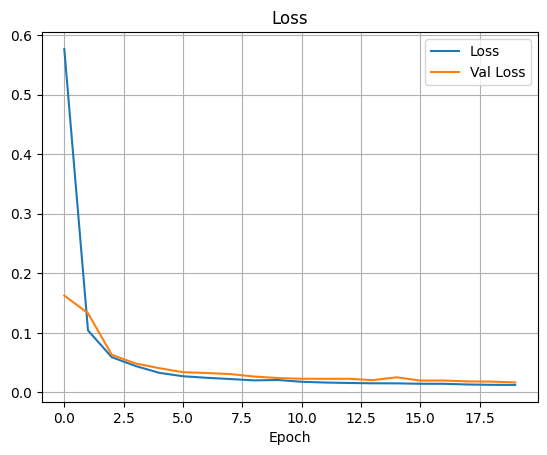

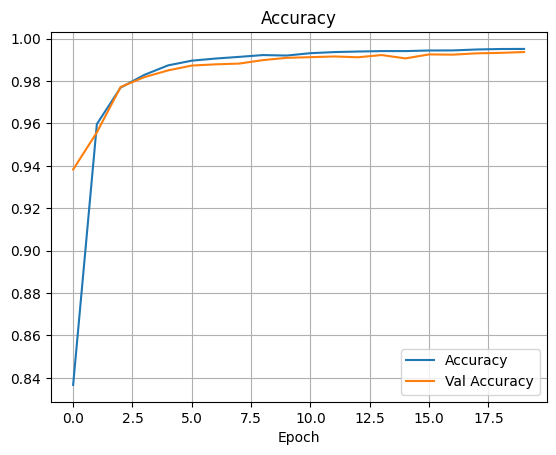

In [20]:
# Training
BATCH_SIZE = 16
N_EPOCHS = 20

hist = u_net_model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=N_EPOCHS,
              validation_split=0.1)

"""
Number of FLOPs = H * W * Cin * Cout
"""

# Check overfit
loss_history = hist.history['loss']
val_loss_history = hist.history['val_loss']

acc_history = hist.history['accuracy']
val_acc_history = hist.history['val_accuracy']

plt.plot(loss_history)
plt.plot(val_loss_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Loss', 'Val Loss'])
plt.title('Loss')
plt.show()

plt.plot(acc_history)
plt.plot(val_acc_history)
plt.grid()
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Val Accuracy'])
plt.title('Accuracy')
plt.show()

u_net_model.save_weights('segmentation_unet_train.h5')

In [21]:
u_net_model.load_weights('segmentation_unet_train.h5')

In [23]:
# Compute IOU and DICE for the UNet model
iou = evaluate_model(u_net_model, x_test,  y_test, iou_coeff)
dice = evaluate_model(u_net_model, x_test,  y_test, dice_coeff)

print(f"The IoU of the trained model is {iou}, while its Dice coefficient is {dice}.")

7/7 [==============================] - 1s 157ms/step
The IoU of the trained model is 0.9646274447441101, while its Dice coefficient is 0.9820796847343445.


1/1 [==============================] - 1s 1s/step


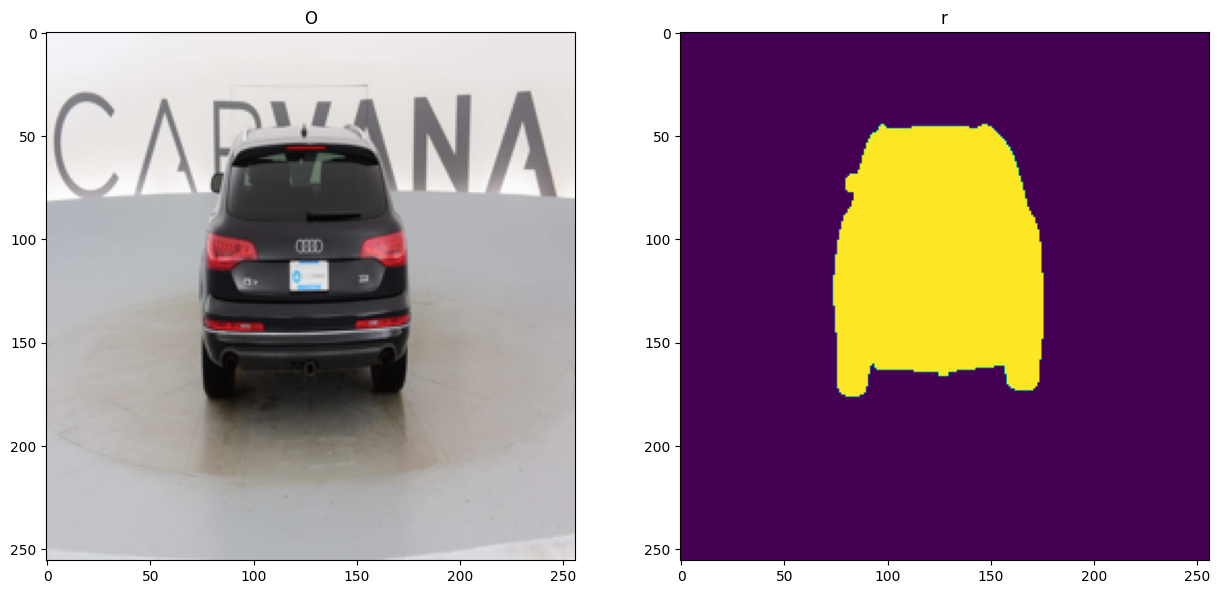

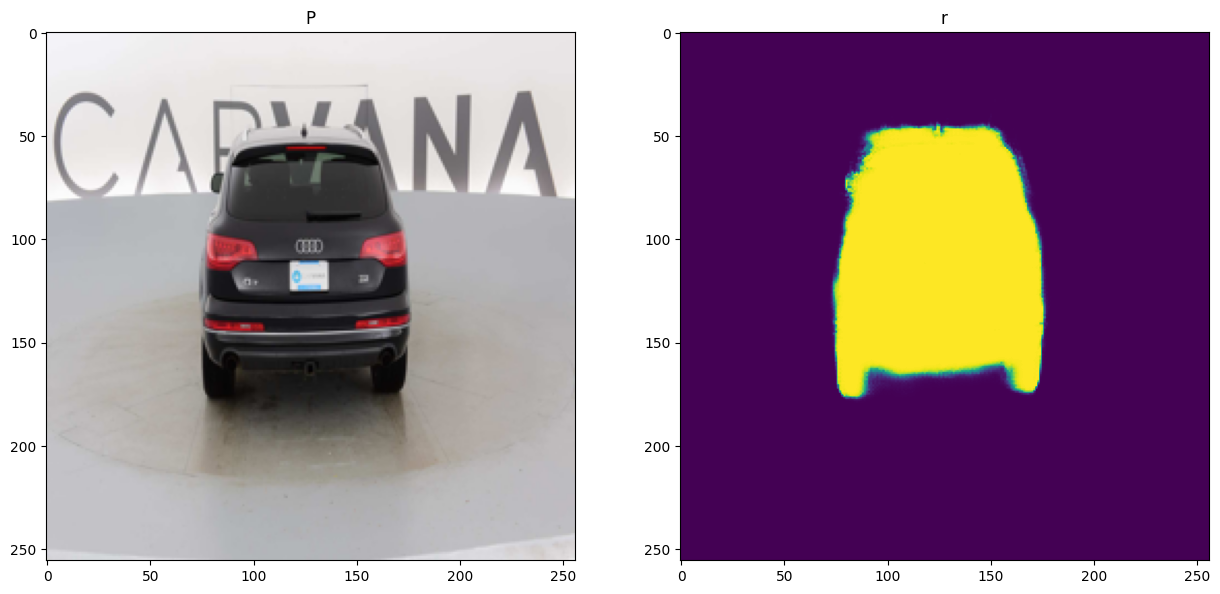

In [25]:
# Qualitative results
y_pred = u_net_model.predict(x_test[:1])

show(x_test[0, :, :], y_test[0, :, :], title='Original')
show(x_test[0, :, :], y_pred[0, :, :, 0], title='Predicted')

## Data augmentation

When using a very powerful model (such as UNet) to solve a Segmentation task, there is a chance that your model will overfit. Given a fixed model, overfit happens strongly if the number of datapoints is small. Thus, a way to reduce overfitting is to enlarge the dimension of the dataset. \\

This is very easy to do in Segmentation. Given a (sufficiently regular) tranformation $T: \mathbb{R}^{m \times n \times c} \to \mathbb{R}^{m \times n \times c}$ and a dataset $\mathbb{D} = \{ (x_i, y_i) \}_{i=1}^N$, where $x_i$ is an image and $y_i$ is a mask with the same dimension of the corresponding image, we can create a new dataset $\mathbb{D}_{ex} = \{ (\tilde{x}_i, \tilde{y}_i) \}_{i=1}^{2N}$ where $\tilde{x}_i = x_i, \tilde{y}_i = y_i$ for $i = 1, \dots, N$, $\tilde{x}_i = T(x_i), \tilde{y}_i = T(y_i)$ for $i = N+1, \dots, 2N$. \\

This procedure can be repeated for multiple transormations $T$, to obtain a larger dataset. \\

*Warning:* Data augmentation via regular transformations $T$ does not add information to the dataset. As a consequence, the training complexity will increase linearly with the number of transformation we apply, without resulting in an improvement on the knowledge the model has. As a consequence, simply using tens of transormations to create a big dataset is not necessary a good idea. I suggest to use at most a couple of them, such as flipping, rotating or shifting.

In [26]:
def apply_transform(x_data, y_data, T):
    N = x_data.shape[0]

    new_x_data = np.zeros_like(x_data)
    new_y_data = np.zeros_like(y_data)

    for i in range(N):
        new_x_data[i] = T(x_data[i])
        new_y_data[i] = T(y_data[i])
    return new_x_data, new_y_data

def augment_data(x_data: np.array, y_data: np.array, transforms: list) -> np.array:
    new_x_data = x_data
    new_y_data = y_data

    for T in transforms:
        new_x, new_y = apply_transform(x_data, y_data, T)

        new_x_data = np.concatenate([new_x_data, new_x], axis=0)
        new_y_data = np.concatenate([new_y_data, new_y], axis=0)
    return new_x_data, new_y_data

# Augment our data with flipud and fliplr
transforms = [np.flipud, np.fliplr]
augmented_x_train, augmented_y_train = augment_data(x_train, y_train, transforms)